# SHAP - Permutation approximation

- [Online Course](https://www.trainindata.com/p/machine-learning-interpretability)

In this notebook, we'll use the approximation of Shapley values that uses permutation. Check out the theory video to understand how this calculation of SHAP values work.

This approximation is **model agnostic** and is the default approximation used by SHAP, when the model is not linear or tree-based and the data has more than 10 features.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

import shap

## Load data

In [2]:
# load the student drop-out dataset

df = pd.read_csv('../student_dropout_trees.csv')

# display top 5 rows
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Admission grade,Displaced,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,dropout
0,0,0,5,0,1,0,122.0,0,127.3,1,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,1
1,0,1,1,1,1,0,160.0,0,142.5,1,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,0
2,0,2,5,2,1,0,122.0,0,124.8,1,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,1
3,0,0,2,3,1,0,122.0,0,119.6,1,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,0
4,1,3,1,4,0,0,100.0,0,141.5,0,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,0


In [3]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("dropout", axis=1),
    df["dropout"],
    test_size=0.2,
    random_state=1,
)

X_train.shape, X_test.shape

((3539, 32), (885, 32))

## Train XGB

In [4]:
gbm = XGBClassifier(random_state=3)

gbm.fit(X_train, y_train)

print(f"model performance; {gbm.score(X_test, y_test)}")

model performance; 0.8711864406779661


## Global importance

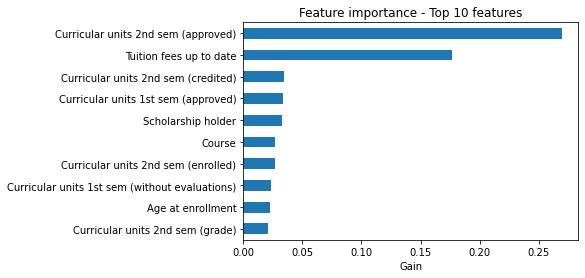

In [5]:
# global importance

imp = pd.Series(gbm.feature_importances_, index=gbm.feature_names_in_)
imp.sort_values(ascending=True, inplace=True)
imp.tail(10).plot.barh()
plt.xlabel("Gain")
plt.title("Feature importance - Top 10 features")
plt.show()

## SHAP - Permutation

### From the main explainer

In [6]:
# set up the explainer
# selects permutation explainer automatically
# when there are > 10 features

# attention: we want to explain the probabilities NOT the class!!!!
explainer = shap.Explainer(gbm.predict_proba, X_train)

# you can also speficy it like this:
# explainer = shap.Explainer(gbm.predict_proba, X_train, algorithm="permutation")

# calling the PermutationExplainer specifically
# explainer = shap.PermutationExplainer(gbm.predict_proba, X_train)

In [7]:
# corroborate that it selected the exact explainer

explainer.__class__

shap.explainers._permutation.PermutationExplainer

In [8]:
# obtain the shap values

shap_values = explainer(X_test)

PermutationExplainer explainer: 886it [02:40,  5.33it/s]                                                               


### Global explanations

With beeswarm plots we can see the range of impact of each feature on the target value. It gives an idea of global importance.

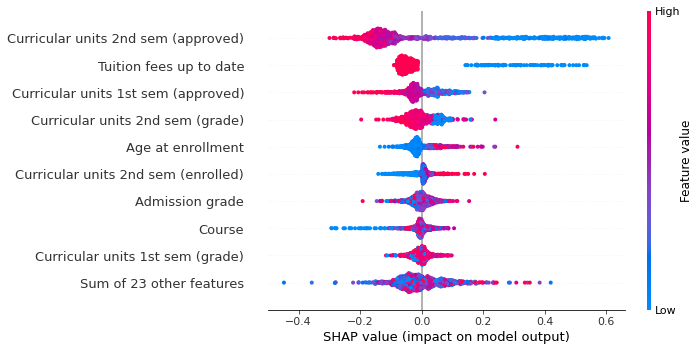

In [9]:
shap.plots.beeswarm(shap_values[:,:,1])

- The larger the SHAP value range, the more important the feature.
- The color indicates the feature magnitude

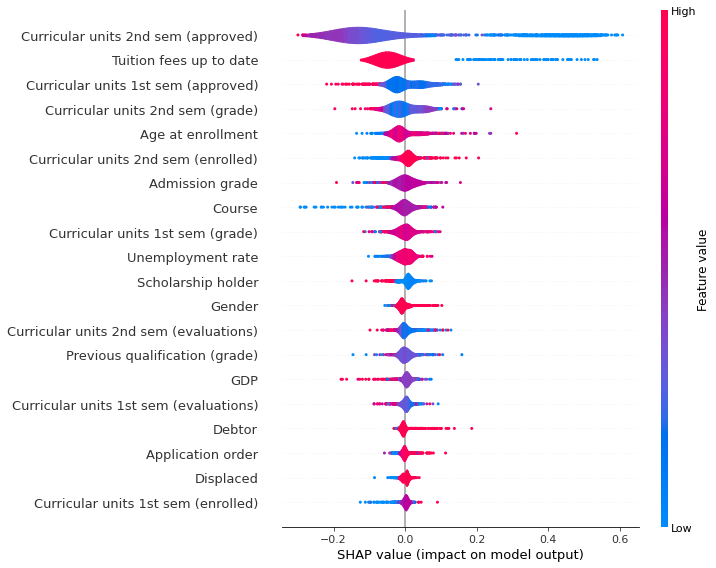

In [10]:
shap.plots.violin(shap_values[:,:,1])

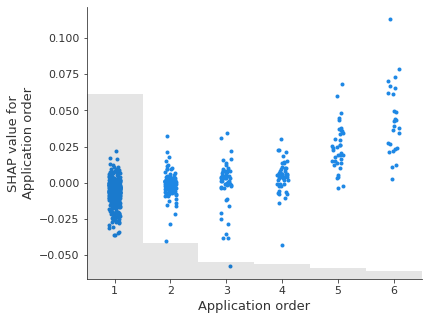

In [11]:
shap.plots.scatter(shap_values[:,"Application order",1])

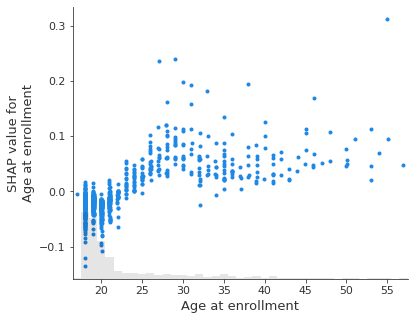

In [12]:
shap.plots.scatter(shap_values[:,"Age at enrollment",1])

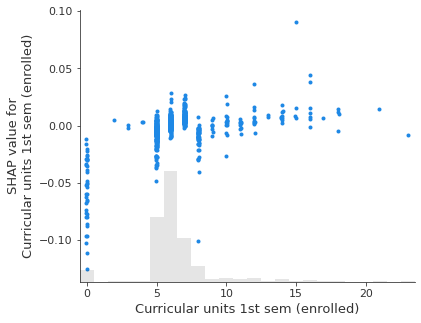

In [13]:
shap.plots.scatter(shap_values[:,"Curricular units 1st sem (enrolled)",1])

### Local explanations

We'll now make waterfall plots for specific samples.

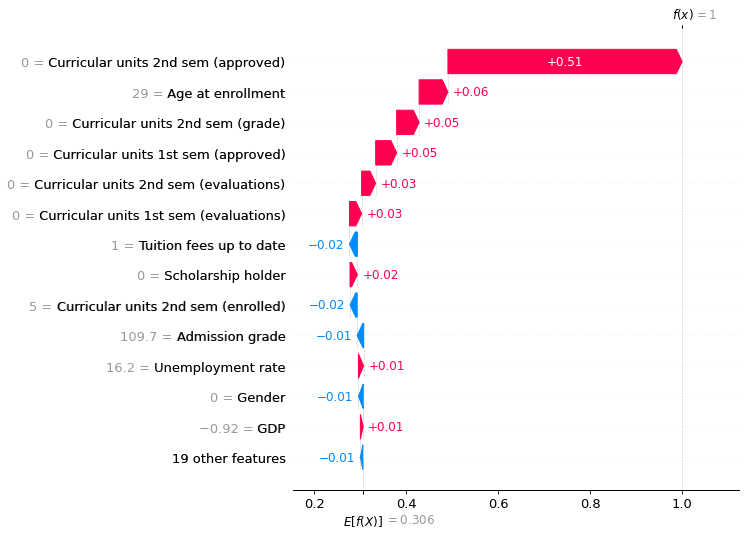

In [14]:
shap.plots.waterfall(shap_values[0, :, 1], max_display=14)

The waterfall plot starts at the expectation without features (mean of the target) and shows how each feature moves the price away (up or down) respect to the origin.

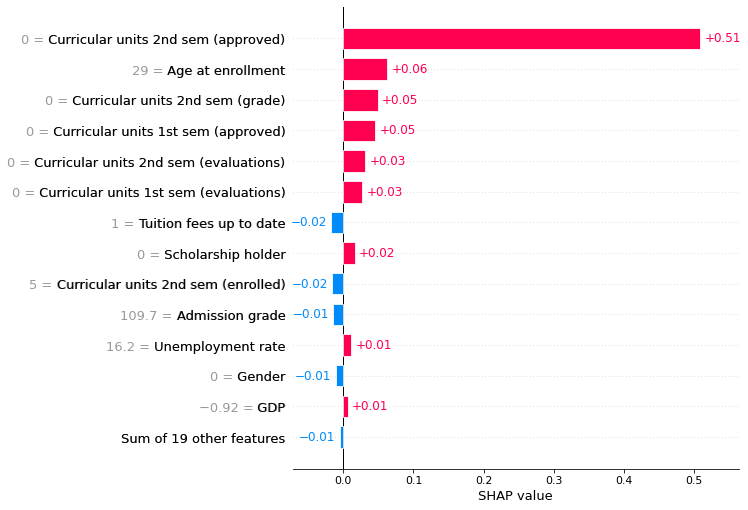

In [15]:
shap.plots.bar(shap_values[0, :, 1], max_display=14)

The bar plot shows how each feature modifies the house price, irrespective of the origin (target mean).

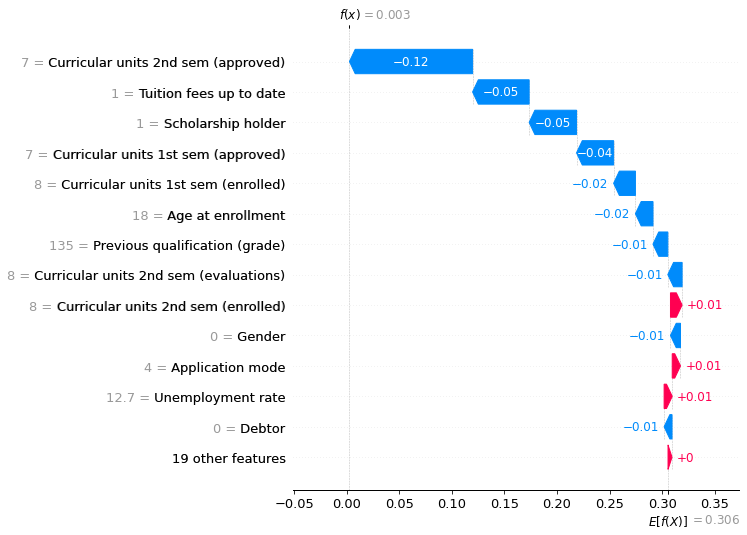

In [16]:
shap.plots.waterfall(shap_values[20, :, 1], max_display=14)

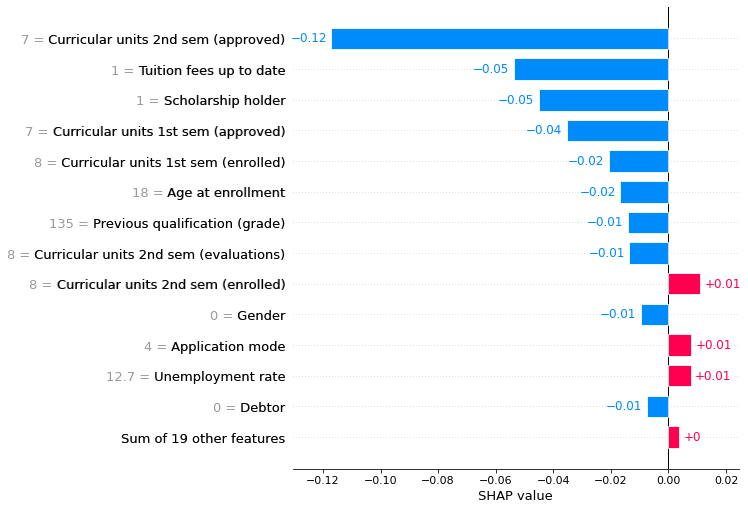

In [17]:
shap.plots.bar(shap_values[20, :, 1], max_display=14)